In [1]:
import json
import pandas as pd
from collections import defaultdict
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
import networkx as nx
from numpy.random import rand, RandomState
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import string
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
import matplotlib
from mpl_toolkits.basemap import Basemap
import geopy
from sklearn.metrics.pairwise import linear_kernel
from geopy.geocoders import Nominatim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import itertools
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def json_to_dict(filename):
    '''
    INPUT: name of json file
    OUTPUT: dictionary with city keys and description values
    take json file and return dictionary
    '''
    di = {}
    english = []
    with open('wordlist.txt') as f:
        for line in f:
            english.append(line.strip('\r\n'))
            english.append(' ')
    english = set(english)

    with open(filename) as data_file:
        data = json.load(data_file)
        for item in data:
            for key in item.keys():
                # remove punctuation, make everything lower case
                txt = ''.join(ch.lower() for ch in item[key] if ch not in set(string.punctuation))
                # remove numbers
                txt = ''.join(c for c in txt if c.isdigit() is False)
                # remove the city name from its own description
                keyparts = key.split(',')
                txt = ' '.join(c for c in txt.split() if c != keyparts[0].lower() and c != keyparts[-1].lower())
                # remove non-english words
                txt = ' '.join(c for c in txt.split() if c in english)
                # populate dictionary
                di[key.strip().strip('\n').encode('ascii', 'ignore')] = txt
    return di

In [3]:
def combine_dictionaries(dict1, dict2, keys_file):
    '''
    INPUT: dictionaries and keys
    OUTPUT: dictionary with combined data and final key names
    take two dictionaries and combine into one
    '''
    combined_dict = {}
    with open(keys_file) as f:
        for line in f:
            d1_key = line.split('|')[0]
            d2_key = line.split('|')[1]
            final_key = line.split('|')[2].strip('\n')

            if d2_key == 'noname':
                combined_dict[final_key] = dict1.get(d1_key)
            elif d1_key == 'noname':
                combined_dict[final_key] = dict2.get(d2_key)
            else:
                combined_dict[final_key] = dict1.get(d1_key) + dict2.get(d2_key)
    return combined_dict

In [4]:
def remove_stopwords(corpus, words_to_add=[]):
    '''
    INPUT: tokenized document corpus, list of words to remove
    OUTPUT: document corpus with stop words removed
    take a list of words to add to stoplist and remove from corpus
    '''
    '''Use the English language stopwords provided by nltk'''
    stops = stopwords.words('english')
    
    '''Add user-requested stopwords'''
    stops.extend(words_to_add)
    
    '''Remove stop words from corpus and return'''
    #tokenized = [word_tokenize(content.lower()) for content in corpus]
    stops = set(stops)
    docs = [[word for word in words if word not in stops]
        for words in corpus]
    
    return docs

In [5]:
def plot_word_frequencies(tokenized_corpus, title):
    '''
    INPUT: tokenized corpus, plot title
    OUTPUT: vocabulary list, word ids, word counts
    take a tokenized corpus, calculate the frequency of each word, and plot
    '''
    '''Build a vocabulary of every unique word in the corpus'''
    vocab_set = set()
    [[vocab_set.add(token) for token in tokens] for tokens in tokenized_corpus]
    vocab = list(vocab_set)
    
    '''Make a dictionary relating word to id number'''
    vocab_dict = {word: i for i, word in enumerate(vocab)}
    
    '''Build word count matrix'''
    word_ids = np.zeros(len(vocab))
    word_counts = np.zeros((len(tokenized_corpus), len(vocab)))
    for doc_id, words in enumerate(tokenized_corpus):
        for word in words:
            word_id = vocab_dict[word]
            word_ids[word_id] = word_id
            word_counts[doc_id][word_id] += 1
    
    '''Count the total number of times each word occurs'''
    values = np.sum(word_counts, axis=0)
    
    '''Plot the results'''
    plt.bar(range(0,len(values)), sorted(values)[::-1], color='green', alpha=0.4)

    plt.xlabel('Word Index')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Chart - {}'.format(title))
    return np.array(values), vocab, word_ids

In [6]:
def build_synonym_list(word_list):
    '''
    INPUT: list of words
    OUTPUT: list containing words and all of their synonyms
    take a list of words and return a list containin all synonyms of those words
    '''
    all_synonyms = []
    for word in word_list:
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
        synlist.append(word.lower())
        all_synonyms.extend([wordnet.lemmatize(w) for w in synlist])
    return all_synonyms

In [7]:
def limit_speech_part(corpus, pts_of_speech = ['ADJ', 'NOUN', 'ADV', 'VERB']):
    '''
    INPUT: tokenized corpus, list of parts of speech to keep
    OUTPUT: list of words to remove
    take a tokenized corpus and return a list of words to remove from that are not in the part of speech list
    '''
    remove_words = []
    for words in corpus:
        for word in words:
            check = 0
            for ps in pts_of_speech:
                check += len(wn.synsets(word, pos=getattr(wn, ps)))
            if check == 0:
                remove_words.append(word)
    return remove_words

In [8]:
def get_personality_words():
    '''
    INPUT: None
    OUTPUT: set of words and their synonyms and lemmas from the personality words text file
    read words from a text file and compile a set of all words in the file, plus their synonyms and lemmas
    '''
    with open('personalitywords_2.txt') as f:
        personality_words = []
        for line in f:
            for word in line.split():
                synonyms = wn.synsets(word.lower())
                synlist = [word.lower()]
                for s in synonyms:
                    synlist = [l.name() for l in s.lemmas()]
                    personality_words.extend([wordnet.lemmatize(w) for w in synlist if len(wn.synsets(w, pos=wn.ADJ))>0])
    return set(personality_words)

In [9]:
def get_features_freq(city_list, cities, stop_wds, doc_bodies):
    '''
    INPUT: list of cities to evaluate, array of all cities, document bodies, stop words to remove from corpus
    OUTPUT: Top 8 features (words) for each city in city_list
    take a corpus and list of cities and return the top features for the documents relating to those cities by term frequency
    '''
    vectorizer = CountVectorizer(stop_words=stop_wds)
    X = vectorizer.fit_transform(doc_bodies)
    features = vectorizer.get_feature_names()
    
    x_dense = X.todense() # convert feature matrix to dense
    for city in city_list:
        ind = np.where(cities==city)[0][0]
        city_words = np.array(x_dense[ind])[0]
        top_indices = np.array(np.argsort(city_words)[::-1][:8])
        print '{}: {}'.format(city, ', '.join(np.array(features)[top_indices]))

In [10]:
def get_features_tfidf(city_list, cities, stop_wds, doc_bodies):
    '''
    INPUT: list of cities to evaluate, array of all cities, document bodies, stop words to remove from corpus
    OUTPUT: Top 8 features (words) for each city in city_list
    take a corpus and list of cities and return the top features for the documents relating to those cities by tfidf
    '''
    vectorizer = TfidfVectorizer(stop_words=stop_wds)
    X = vectorizer.fit_transform(doc_bodies)
    features = vectorizer.get_feature_names()
    
    x_dense = X.todense() # convert feature matrix to dense
    for city in city_list:
        ind = np.where(cities==city)[0][0]
        city_words = np.array(x_dense[ind])[0]
        top_indices = np.array(np.argsort(city_words)[::-1][:8])
        print '{}: {}'.format(city, ', '.join(np.array(features)[top_indices]))

### Initial data formatting:
Convert to dictionary, combine dictionaries, remove cities without text, convert to data frame

In [11]:
rs_dict = json_to_dict('../scraping/ricksteves_articles_blogs_R01.json')
ta_dict = json_to_dict('../scraping/europe_city_reviews2.json')

empty_count = 0
for k in ta_dict:
    if len(ta_dict[k]) < 100:
        empty_count += 1
print empty_count

key_list = set(rs_dict.keys() + ta_dict.keys())
europe_dict = dict()
for key in key_list:
    europe_dict[key] = str(rs_dict.get(key)) + str(ta_dict.get(key))
    
# remove cities which contain little or no text
europe_dict = {key: value for key, value in europe_dict.items() if len(value) > 200}
for k in europe_dict:
    if len(europe_dict[k]) < 100:
        print '\n', k
        print europe_dict[k]

# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(europe_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
# doc_bodies = cities_df['description']
doc_bodies = cities_df['description'].values
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]
cities = cities_df.index.values

wordnet = WordNetLemmatizer()
docs_wordnet = [' '.join([wordnet.lemmatize(word) for word in words.split()]) for words in doc_bodies]
tokenized_corpus_wn = [word_tokenize(content.lower()) for content in docs_wordnet]

67


### nltk stop words removed

In [12]:
tokenized_corpus_0 = remove_stopwords(tokenized_corpus)
print 'Most Common Words:'
get_features_freq(['Venice, Italy'], cities, stopwords.words('english'), doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stopwords.words('english'), doc_bodies)

Most Common Words:
Venice, Italy: one, see, great, tour, church, time, beautiful, bridge

Tfidf Most Important Words:
Venice, Italy: canal, bridge, one, venetian, see, church, beautiful, tour


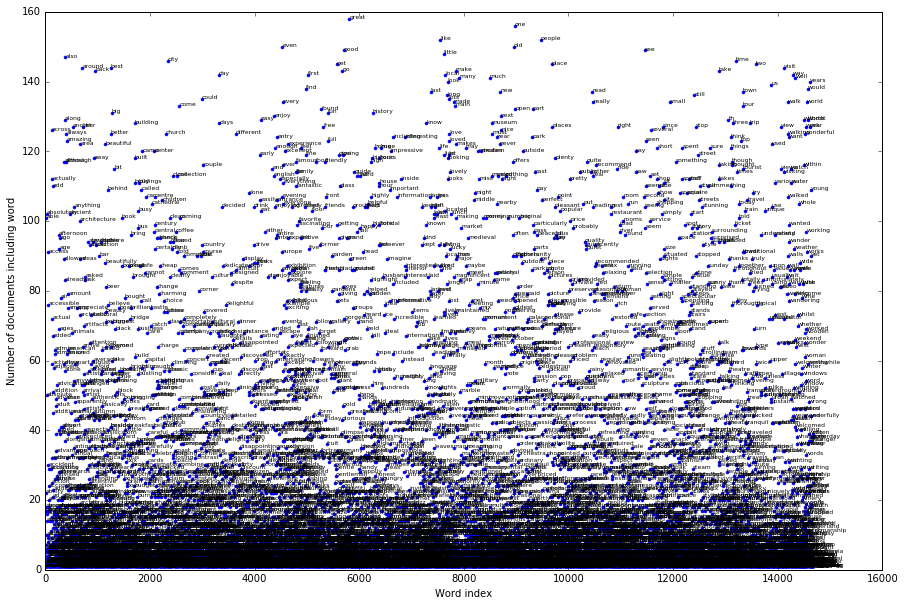

In [13]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()

x_dense = X.todense() # convert feature matrix to dense
# for city in city_list:
#     ind = np.where(cities==city)[0][0]
#     city_words = np.array(x_dense[ind])[0]
#     top_indices = np.array(np.argsort(city_words)[::-1][:8])
#     print '{}: {}'.format(city, ', '.join(np.array(features)[top_indices]))
fig = plt.figure(figsize=(15,10))
num_docs = []
for i in xrange(x_dense.shape[1]):
    word_col = x_dense[:,i]
    num_docs.append(np.count_nonzero(word_col))

plt.plot(range(x_dense.shape[1]), num_docs, '.')
for i in xrange(x_dense.shape[1]):
    plt.text(i, num_docs[i], features[i], fontsize=6)
plt.xlabel('Word index')
plt.ylabel('Number of documents including word')

In [14]:
tagged = []
rm = []
for doc in tokenized_corpus_0:
    rm.extend([word for word, tag in pos_tag(doc) if 'JJ' not in tag])
    tagged.extend(pos_tag(doc))
counts = Counter(tag for word,tag in tagged)
print counts
print len(rm)

Counter({'NN': 555477, 'JJ': 429729, 'RB': 145894, 'NNS': 104490, 'VBP': 72039, 'VBG': 71607, 'VBD': 59187, 'VB': 51316, 'IN': 48222, 'VBN': 40194, 'CD': 21938, 'MD': 19176, 'VBZ': 15694, 'JJS': 8246, 'PRP': 5370, 'JJR': 4942, 'DT': 4886, 'FW': 2987, 'RBR': 2971, 'RP': 1523, 'CC': 1405, 'NNP': 658, 'RBS': 424, 'WDT': 243, 'WRB': 204, 'WP': 158, 'WP$': 140, '.': 61, 'PDT': 37, 'UH': 35, 'PRP$': 20, 'POS': 10, 'TO': 10, 'EX': 7, 'SYM': 3})
1226386


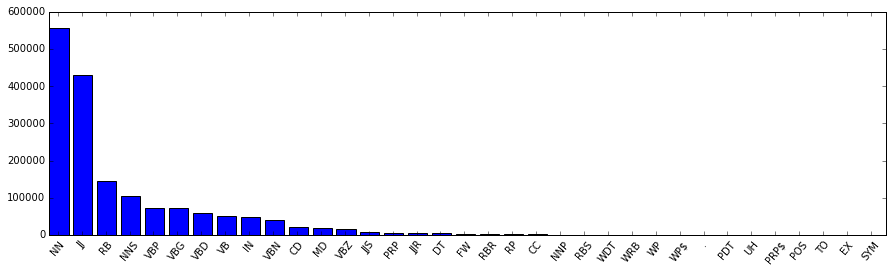

In [15]:
ks = np.array(counts.keys())
vs = np.array(counts.values())
sort_inds = np.array(np.argsort(vs)[::-1])

ind = np.arange(len(ks))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(15,4))
top_indices = np.array(np.argsort(vs)[::-1][:8])
plt.bar(range(0,len(vs)), vs[sort_inds])
ax.set_xticks(ind + width)
ax.set_xticklabels(ks[sort_inds], rotation=50)
plt.show()

### START HERE

In [16]:
# read each word, assign pos_tag. If pos tag is noun, append dictionary
noun_dict = defaultdict(list)
verb_dict = defaultdict(list)
adj_dict = defaultdict(list)
adv_dict = defaultdict(list)

for i, doc in enumerate(tokenized_corpus_0):
    pos_tag(doc)
    for word, tag in pos_tag(doc):
        if 'NN' in tag:
            noun_dict[word].append(i)
        if 'JJ' in tag:
            adj_dict[word].append(i)
        if 'VB' in tag:
            verb_dict[word].append(i)
        if 'RB' in tag:
            adv_dict[word].append(i)

#     rm.extend([word for word, tag in pos_tag(doc) if 'JJ' not in tag])
#     tagged.extend(pos_tag(doc))
# counts = Counter(tag for word,tag in tagged)

In [17]:
nouns = np.array(noun_dict.keys())
noun_count = np.array(noun_dict.values())
doc_freq = []
overallcount = []
for row in noun_count:
    doc_freq.append(len(set(row)))
    overallcount.append(len(row))

print nouns[np.array(doc_freq) > 50]

['music' 'capital' 'relax' 'glass' 'example' 'travel' 'beauty' 'types'
 'wine' 'service' 'person' 'doors' 'rick' 'lots' 'nature' 'country' 'life'
 'things' 'steps' 'right' 'people' 'son' 'offer' 'floor' 'time' 'choice'
 'minute' 'team' 'sign' 'love' 'winter' 'spot' 'st' 'years' 'course'
 'attraction' 'square' 'city' 'saw' 'take' 'walking' 'boat' 'summer' 'rest'
 'traffic' 'world' 'stone' 'side' 'th' 'pass' 'section' 'hours'
 'experience' 'door' 'company' 'learn' 'beautiful' 'sense' 'information'
 'signs' 'week' 'imagine' 'castle' 'number' 'stairs' 'play' 'plan' 'taxi'
 'river' 'see' 'sea' 'europe' 'let' 'church' 'read' 'admission' 'location'
 'couple' 'sight' 'anything' 'spending' 'line' 'sides' 'age' 'garden' 'try'
 'video' 'animals' 'pieces' 'wander' 'scene' 'system' 'fact' 'stuff' 'site'
 'drink' 'audio' 'rooms' 'passion' 'construction' 'places' 'monument'
 'variety' 'details' 'chance' 'gardens' 'worth' 'daughter' 'items' 'word'
 'work' 'woman' 'boats' 'order' 'office' 'coffee' 'bre

In [18]:
words = np.array(adj_dict.keys())
word_count = np.array(adj_dict.values())
doc_freq = []
overallcount = []
for row in word_count:
    doc_freq.append(len(set(row)))
    overallcount.append(len(row))

uncommonadj = list(words[(np.array(doc_freq) < 2) & (np.array(overallcount) < 2)])

### Non-personality words removed

In [19]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + list(nouns) + uncommonadj)
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()

kmeans = KMeans(n_clusters=12)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

top features for each cluster:
0: syncopated, romantically, stylishly, great, sublime, lakeside, notably
1: great, us, would, affiliated, offered, valuable, two
2: great, old, really, also, many, around, small
3: friendly, great, zest, farthest, fanned, fanning, far
4: old, great, two, many, around, new, main
5: lousy, unpolished, may, victorious, contagious, bulging, wrinkled
6: created, former, many, nearby, defined, hardworking, industrial
7: along, ensuing, exhaling, trendsetting, disclose, mistaken, expose
8: lovely, maintained, decided, great, drastically, nicely, short
9: great, new, old, still, many, big, even
10: great, lovely, really, around, would, also, many
11: rushing, old, toward, deprived, tanned, wiry, elongated


In [20]:
personalities = get_personality_words()
non_personalities = []
for words in tokenized_corpus_0:
    for word in words:
        syns = []
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
            syns.extend(synlist)
        if len(set.intersection(set(syns), personalities)) == 0:
            non_personalities.append(word)
            
stop_wds = set(stopwords.words('english') + rm)
tokenized_corpus_1 = remove_stopwords(tokenized_corpus_0, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

12885 stopwords removed

Most Common Words:
Venice, Italy: great, grand, many, small, main, huge, real, full

Tfidf Most Important Words:
Venice, Italy: great, grand, many, small, main, real, huge, full


### nltk stop words and nouns removed

In [21]:
nouns = limit_speech_part(tokenized_corpus_1, pts_of_speech = ['ADJ', 'ADJ_SAT', 'ADV', 'VERB'])
stop_wds = set(stopwords.words('english') + non_personalities + nouns)
tokenized_corpus_2 = remove_stopwords(tokenized_corpus_1, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

13820 stopwords removed

Most Common Words:
Venice, Italy: see, great, tour, get, go, well, grand, really

Tfidf Most Important Words:
Venice, Italy: see, tour, great, grand, get, well, go, square


### nltk stop words, nouns and verbs removed

In [22]:
verbs = limit_speech_part(tokenized_corpus_2, pts_of_speech = ['ADJ', 'ADJ_SAT', 'ADV'])
stop_wds = set(stopwords.words('english') + non_personalities + nouns + verbs)
tokenized_corpus_3 = remove_stopwords(tokenized_corpus_2, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

13828 stopwords removed

Most Common Words:
Venice, Italy: see, great, tour, get, go, well, grand, really

Tfidf Most Important Words:
Venice, Italy: see, tour, great, grand, get, well, go, square


### nltk stop words, nouns, verbs and adverbs removed

In [23]:
adverbs = limit_speech_part(tokenized_corpus_3, pts_of_speech = ['ADJ', 'ADJ_SAT'])
stop_wds = set(stopwords.words('english') + non_personalities + nouns + verbs + adverbs)
tokenized_corpus_4 = remove_stopwords(tokenized_corpus_3, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

13828 stopwords removed

Most Common Words:
Venice, Italy: see, great, tour, get, go, well, grand, really

Tfidf Most Important Words:
Venice, Italy: see, tour, great, grand, get, well, go, square


### nltk stop words, nouns, verbs, adverbs, and common words removed

Word in corpus: 210
Maximum word frequency: 18080
13836 stopwords removed

Most Common Words:
Venice, Italy: see, tour, get, well, go, grand, really, nice
Paris, France: tour, see, good, get, new, big, grand, made
Amsterdam, Netherlands: get, see, new, big, go, good, light, hard

Tfidf Most Important Words:
Venice, Italy: see, tour, grand, get, well, go, square, really
Paris, France: tour, grand, see, good, get, new, big, made
Amsterdam, Netherlands: get, new, see, big, light, golden, go, hard


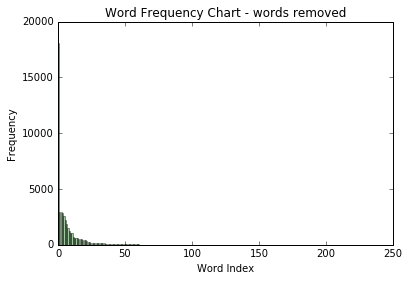

In [24]:
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus_4, 'words removed')
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))
vocab_dict = {i: word for i, word in enumerate(vocab)}
# remove any words that are very common
commonwords = word_ids[values > 3000]
common_removelist = [vocab_dict[c] for c in commonwords]
# print common_removelist

two_letter = [word for word in vocab if len(word) < 3]
# print two_letter
add = 'last, found, spent, open, going, long, close, full, seeing, frank, sure, located, taking, able, world'.split(', ')
stop_wds = set(stopwords.words('english') + non_personalities + nouns + verbs + add + adverbs + common_removelist + two_letter)
tokenized_corpus_5 = remove_stopwords(tokenized_corpus_4, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
get_features_freq(['Paris, France'], cities, stop_wds, doc_bodies)
get_features_freq(['Amsterdam, Netherlands'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)
get_features_tfidf(['Paris, France'], cities, stop_wds, doc_bodies)
get_features_tfidf(['Amsterdam, Netherlands'], cities, stop_wds, doc_bodies)

In [25]:
commonwords = word_ids[values > 1500]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

['real', 'big', 'large', 'new', 'full', 'great', 'last', 'able']


In [26]:
# Make a dictionary of personality words and their synonyms
pers_dict = dict()
for trait in personalities:
    personality_words = []
    synonyms = wn.synsets(trait.lower())
    synlist = [word.lower()]
    for s in synonyms:
        synlist = [l.name() for l in s.lemmas()]
        personality_words.extend([wordnet.lemmatize(w) for w in synlist if len(wn.synsets(w, pos=wn.ADJ))>0])
    pers_dict[trait] = ' '.join(personality_words)

# Convert dictionary into dataframe
traits_df = pd.DataFrame.from_dict(pers_dict, orient='index', dtype=None)
traits_df.columns = ['synonyms']

# Extract cities and their descripitions from dataframe
pers_doc_bodies = traits_df['synonyms'].values
pers_tokenized_corpus = [word_tokenize(content.lower()) for content in pers_doc_bodies]
traits = traits_df.index.values

# Vectorize
remove = ['mercenary', 'favourable', 'ill', 'high', 'ridden', 'hag', 'low', 'minded', 'well', 'self', 'pietistical',
         'shoulder', 'meagre', 'zippy', 'long', 'prospicient', 'flown', 'janus', 'far', 'finished', 'goosy',
         'anserine', 'pharisaical', 'outre', 'gonzo', 'pharisaic', 'pietistic', 'thou', 'ho', 'hum', 'silver',
         'scotch', 'plaguy', 'faced', 'at_sea', 'double', 'crabbed', 'patient_of', 'first', 'two', 'laced',
         'tongued', 'sizable', 'sizeable', 'slushy', 'sticking_out', 'wall', 'close', 'aerial', 'aery', 'aeriform',
         'bribable', 'for_sale']
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english')+remove)
X = vectorizer.fit_transform(pers_doc_bodies)
features = vectorizer.get_feature_names()

# Apply kmeans clustering and identify top features for each cluster
kmeans = KMeans(n_clusters=12)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

top features for each cluster:
0: open, positive, divine, good, powerful, ethereal, conservative
1: wise, knowing, fresh, smart, impertinent, knowledgeable, saucy
2: profound, unsounded, heavy, sound, unplumbed, unfathomed, fundamental
3: informative, enlightening, illuminating, instructive, informatory, clear, light
4: talkative, chatty, talky, gabby, loquacious, garrulous, blabbermouthed
5: comfortable, easy, prosperous, heeled, situated, fixed, comfy
6: fascinating, captivating, enchanting, bewitching, entrancing, enthralling, riveting
7: deep, cryptic, cryptical, mysterious, inscrutable, mystifying, abstruse
8: reflective, broody, brooding, musing, contemplative, pensive, meditative
9: gay, merry, mirthful, comic, alert, jolly, funny
10: flash, gaudy, loud, cheap, meretricious, flashy, brassy
11: modern, mod, advanced, innovative, modernistic, forward, looking


In [27]:
pers_dict2 = dict()
for trait in personalities:
    personality_words = []
    synonyms = wn.synsets(trait.lower())
    synlist = [trait.lower()]
    for s in synonyms:
        synlist = [l.name() for l in s.lemmas()]
        personality_words.extend([wordnet.lemmatize(w) for w in synlist if len(wn.synsets(w, pos=wn.ADJ))>0])
    pers_dict2[trait] = personality_words

syns = set([item for sublist in pers_dict2.values() for item in sublist])

edges = []
for syn in syns: 
    keys_lst = []
    keys_lst = [key for key, value in pers_dict2.items() if syn in value]
    if len(keys_lst) > 1:
        edges.extend(list(itertools.combinations(keys_lst, 2)))
        
with open('personality_edges.txt', 'w') as f:
    for edge in edges:
        f.write(edge[0] + ' ' + edge[1] + '\n')

[u'cultivated', u'civilized', u'genteel', u'polite', u'civilised']


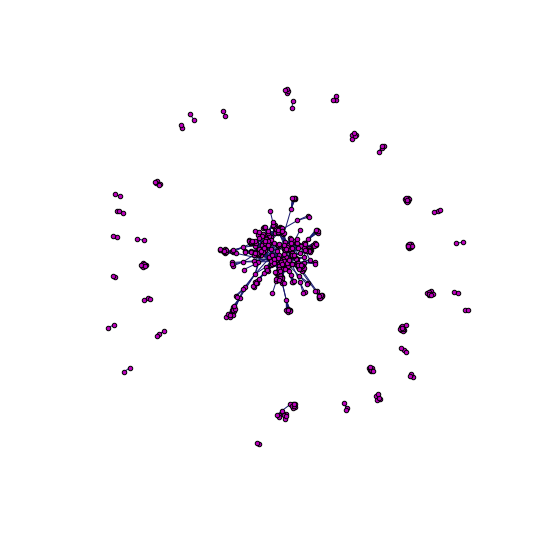

In [28]:
# plot all of the nodes and edges in the graph
fig = plt.figure(figsize = (7, 7))
G = nx.read_edgelist('personality_edges.txt')
pos = nx.spring_layout(G)
# print len(list(nx.connected_components(G)))
wordlist = ['cultured']
for word in wordlist:
    print G.neighbors(word)

nx.draw(G, pos, node_size=20, node_color='m', edge_color='#191970')
plt.show()


# for l in list(nx.connected_components(G)):
#     print l, '\n'

In [29]:
with open('personalities.txt') as f:
    for line in f:
        personalities = line.strip('\n').split(', ') # read words on each line of file
        
        personality_dict = dict()  # record synonyms and lemmas for each word in a dictionary
        for trait in personalities:
            personality_words = [trait]
            for s in wn.synsets(trait.lower()):
                synlist = [l.name() for l in s.lemmas()]
                personality_words.extend([wordnet.lemmatize(w) for w in synlist])
            personality_dict[trait] = set(personality_words)

        syns = set([item for sublist in personality_dict.values() for item in sublist])
        
        edge_list = []
        for syn in syns: 
            keys_lst = [key for key, value in personality_dict.items() if syn in value]
            if len(keys_lst) > 1:
                edge_list.extend(list(itertools.combinations(keys_lst, 2)))
        
        # create a graph
        G=nx.Graph()
        G.add_edges_from(edge_list)

        max_deg = Counter(nx.degree_centrality(G)).most_common(1)[0][0]
        max_eig = Counter(nx.eigenvector_centrality(G)).most_common(1)[0][0]
        nbrs = G.neighbors(max_deg)
        print '\nmost important word (degree centrality): ', max_deg
        print 'most important word (eigenvector centrality): ', max_eig


        if len(nbrs) < 10:
            lst2 = []
            for nbr in nbrs:
                lst2.extend([g for g in G.neighbors(nbr) if g not in nbrs and g != max_deg])
            nbrs.extend(lst2)

        print len(nbrs), 'neighbors =', ', '.join(nbrs)
        if len(nbrs) < 10:
            print syns
# nx.draw(G, pos, node_size=20, node_color='m', edge_color='#191970')
# nx.draw_networkx_nodes(G, pos, nodelist=[max_deg, max_eig], node_color='#EE1289', node_size=100)
# plt.show()

db = np.append(doc_bodies, ' '.join(nbrs))
stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stops)

X = vectorizer.fit_transform(db)
# print len(doc_bodies)
# 1. Compute cosine similarity
cosine_similarities = linear_kernel(X, X)

sims = np.zeros([len(db),])
# 2. Print out similarities
for i, doc1 in enumerate(db):
    for j, doc2 in enumerate(db):
        if i == len(db) - 1 and j < len(db) -1:
            sims[j] = cosine_similarities[i, j]
top10 = np.argsort(sims)[::-1][:10]
print '\n'
for i in top10:
    print cities[i], ':',', '.join(set(tokenized_corpus[i]) & set(nbrs))


most important word (degree centrality):  quiet
most important word (eigenvector centrality):  quiet
12 neighbors = calming, serene, rest, repose, calm, sedate, relaxation, tranquil, serenity, comforting, comforting, comforting

most important word (degree centrality):  delight
most important word (eigenvector centrality):  delight
7 neighbors = enjoy, jollify, enjoyment, revel, revelry, enjoyed, make_happy
set([u'intoxicate', u'festal', u'lift_up', u'spanking', 'playful', u'plight', u'jolly', 'enjoyed', 'happiness', u'make_happy', u'wage', u'zippy', u'jollify', 'recreational', u'snappy', u'make_merry', u'take', u'prosecute', 'elated', u'good-time', u'felicity', u'rattling', u'make_whoopie', u'relish', u'enjoyable', u'risible', u'harbor', u'full_of_life', u'mirthful', u'racy', u'engross', 'delightful', u'springy', u'enrapture', u'enchant', u'amusive', 'enjoy', u'charter', 'diverting', u'play', 'engaging', u'revel', u'bouncy', u'racket', u'sport', u'wassail', u'transport', u'employ', '

In [30]:
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')

geolocator = Nominatim()
xpts = []
ypts = []
ctlst = []
sim = []
for i, city in enumerate(cities):
    location = geolocator.geocode(city, timeout=10)
    if location is not None:
        xpt, ypt = m(location.longitude, location.latitude)
        sim.append(sims[i])
        ctlst.append(city)
        xpts.append(xpt)
        ypts.append(ypt)

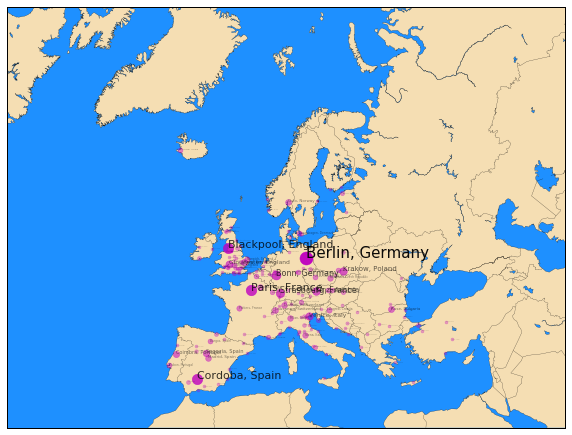

In [31]:
plt.figure(figsize=(10, 10))
sim = np.array(sim)
sz = 20. * sim / max(sim) + 6
alp = (sim / max(sim))/1.5 + 0.3
fs = 15 * sim / max(sim)

for i in xrange(len(xpts)):
    plt.plot(xpts[i], ypts[i], '.', markersize=sz[i], color='m', alpha=alp[i])
    plt.text(xpts[i], ypts[i], ctlst[i], fontsize=int(fs[i]), alpha=alp[i])

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
# plt.savefig('city_example.png', bbox_inches='tight')
m.drawmapboundary(fill_color='#1E90FF')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='#F5DEB3',lake_color='#1E90FF')
plt.show()

In [32]:
synonyms = wn.synsets('relaxing'.lower())

synlist = []
for s in synonyms:
    synlist = [l.name() for l in s.lemmas()]
    personality_words.extend([wordnet.lemmatize(w) for w in synlist])
print set(personality_words)
print synlist

set([u'unwind', u'loosen', u'square', u'reposeful', 'substantial', u'loosen_up', u'slack_up', u'satisfying', u'relaxing', u'strong', u'unstrain', u'real', u'loose', u'unbend', u'relax', u'material', u'decompress', u'significant', u'slow_down', u'slack', u'slacken', u'solid', u'unlax', u'substantive', u'hearty', u'make_relaxed', u'restful'])
[u'restful', u'reposeful', u'relaxing']


## Plot word frequency of remaining words

Word in corpus: 210
Maximum word frequency: 18080


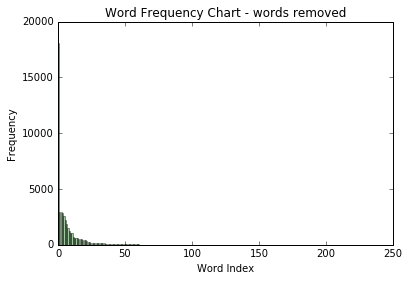

In [33]:
# tokenized_corpus = tokenized_corpus_4
# doc_bodies = docs_wordnet
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus_4, 'words removed')
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [34]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove any words that are very common
commonwords = word_ids[values > 4000]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

['great']


## Remove stopwords and plot new frequency

Word in corpus: 14843
Maximum word frequency: 18080


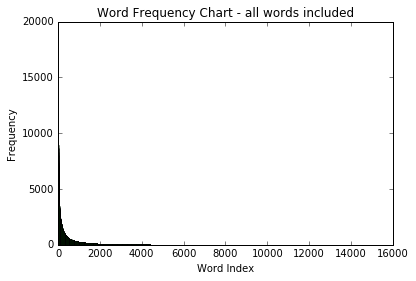

In [35]:
tokenized_corpus_1 = remove_stopwords(tokenized_corpus)
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus_1, 'all words included')
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [36]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove any words that are very common
commonwords = word_ids[values > 2000]
common_removelist = [vocab_dict[c] for c in commonwords]

uncommonwords = word_ids[values == 1]
uncommon_removelist = [vocab_dict[c] for c in uncommonwords]

# remove two letter words|
two_letter = [word for word in vocab if len(word) < 3]

# Limit by part of speech
remove_non = limit_speech_part(tokenized_corpus, ['ADJ', 'ADV'])

In [37]:
personalities = get_personality_words()
non_personalities = []
for words in tokenized_corpus:
    for word in words:
        syns = []
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
            syns.extend(synlist)
        if len(set.intersection(set(syns), personalities)) == 0:
            non_personalities.append(word)


['want', 'cathedral', 'best', 'lots', 'much', 'things', 'right', 'old', 'people', 'inside', 'time', 'along', 'love', 'years', 'square', 'quite', 'one', 'open', 'city', 'take', 'walking', 'going', 'around', 'th', 'large', 'small', 'full', 'hours', 'experience', 'beautiful', 'information', 'always', 'found', 'really', 'castle', 'also', 'river', 'see', 'last', 'whole', 'church', 'read', 'us', 'great', 'next', 'could', 'building', 'places', 'worth', 'highly', 'easy', 'way', 'entrance', 'still', 'looking', 'area', 'lot', 'family', 'history', 'food', 'close', 'look', 'guide', 'used', 'go', 'friendly', 'wonderful', 'located', 'times', 'need', 'main', 'well', 'museum', 'across', 'even', 'new', 'fantastic', 'recommend', 'amazing', 'side', 'street', 'palace', 'modern', 'stop', 'architecture', 'lovely', 'near', 'make', 'visit', 'interesting', 'views', 'first', 'long', 'little', 'especially', 'get', 'many', 'different', 'tour', 'two', 'town', 'hour', 'good', 'house', 'park', 'part', 'built', 'find

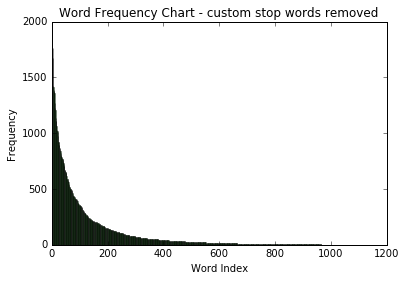

In [38]:
remove_more = ['turkish', 'german', 'english', 'russian', 'ukrainian', 'lithuanian', 'spanish', 'serbian',
               'armenian', 'italian', 'greek', 'croatian', 'finnish', 'polish', 'estonian', 'french', 'swiss',
               'czech', 'latvian', 'irish', 'danish', 'macedonian', 'welsh', 'bulgarian', 'british', 'norwegian',
               'scottish', 'belgian', 'american', 'hungarian', 'cyrillic', 'european','dutch','gaelic','yugoslav',
               'scandinavian','bosnia','herzegovina', 'europe', 'america', 'andorra', 'petersburg', 'catherine',
               'romanov', 'peter', 'favoritethis', 'liechtenstein', 'austrian', 'flemish', 'georgian', 'tuscan', 
               'nazi', 'byzantine', 'roman', 'venetian', 'large', 'main', 'found', 'enough', 'located', 'done',
               'second', 'full', 'booked', 'right', 'square', 'rum', 'ordered', 'easy', 'spent', 'sure', 'august',
              'near', 'fly', 'still' ,'flip', 'becoming', 'minute', 'laid', 'arch', 'set', 'long', 'black', 'animal',
              'longer', 'used','able', 'whole', 'last', 'big', 'high', 'star', 'come', 'close', 'bit', 'line' ,'new',
              'train', 'think', 'left', 'end', 'say', 'child', 'pas', 'drive', 'white', 'offer', 'guided', 'experience',
              'space', 'know', 'cannot', 'situated', 'closed', 'thorough', 'fantastic', 'excellent', 'better','special',
               'perfect','taking','short','house', 'base', 'golden', 'blue', 'gold', 'driving','inner','kart','dress','pronounced',
              'loved','ms','perpendicular','open','game','past','experienced','contained','home', 'weather', 'age', 
               'wanted', 'start','dog', 'ground','el','variety', 'range', 'hard', 'check', 'spot', 'sculpture','floor','point',
              'spot', 'give', 'thought','quarter','seat', 'lower','behind','however','late','nearly','fairly','live',
              'interested']


# remove any words that are very common
common = word_ids[values > 2000]
common_list = [vocab_dict[c] for c in common]
tokenized_corpus = remove_stopwords(tokenized_corpus, common_removelist + two_letter + uncommon_removelist + 
                                    remove_more + non_personalities + common_list)

# tokenized_corpus = remove_stopwords(tokenized_corpus)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'custom stop words removed')

vocab_dict = {i: word for i, word in enumerate(vocab)}


print common_list
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [39]:
stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stops + remove_more + remove_non + common_removelist + common_list + non_personalities)
# vectorizer = CountVectorizer(stop_words=stops + remove_more + uncommon_removelist + common_list +
#                              common_removelist + non_personalities)
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()

In [40]:
x_dense = X.todense()
# print x_dense
# print x_dense.max()
for i, doc in enumerate(x_dense):
    d = np.array(doc)[0]
    print cities[i]
    top_indices = np.array(np.argsort(d)[::-1][:8])
    print np.array(features)[top_indices]

Derby, England
[u'moved' u'essential' u'cheering' u'broke' u'confident' u'working'
 u'accommodating' u'keen']
Bilbao, Spain
[u'clean' u'pleasant' u'central' u'given' u'steep' u'warm' u'fluid'
 u'appealing']
Washington, United Kingdom
[u'starting' u'straight' u'accessible' u'civil' u'filled' u'fresh'
 u'inspirational' u'expansive']
Olomouc, Czech Republic
[u'holy' u'religious' u'spiritual' u'largest' u'unique' u'biggest'
 u'easily' u'quiet']
Vaduz, Liechtenstein
[u'quick' u'grand' u'yet' u'fluid' u'fluent' u'flourishing' u'flop'
 u'flashy']
Exeter, England
[u'quiet' u'national' u'pretty' u'starting' u'sunny' u'yet' u'fishy'
 u'flourishing']
Caligari, Italy
[u'comfortable' u'informative' u'clear' u'magnificent' u'glad' u'learned'
 u'brilliant' u'adequate']
Southampton, England
[u'bad' u'former' u'given' u'inexpensive' u'unique' u'polite' u'refreshing'
 u'adult']
Zamora, Spain
[u'clean' u'civil' u'crossed' u'leisurely' u'shady' u'delightful'
 u'inspired' u'complete']
Ravenna, Italy
[u'qui

In [41]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-13:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

# 3. Print out the titles of a random sample of the articles assigned to each
# cluster to get a sense of the topic.
# assigned_cluster = kmeans.transform(X).argmin(axis=1)
# for i in range(kmeans.n_clusters):
#     cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
#     sample_cities = np.random.choice(cluster, 2, replace=False)
#     print "cluster %d:" % i
#     for city in sample_cities:
#         print "    %s" % cities[city].strip('\n')

top features for each cluster:
0: round, easily, pretty, marvelous, bigger, reasonably, brilliant, thoroughly, opened, glad, lucky, hot
1: real, round, busy, informative, seeing, pleasant, clean, pretty, quiet, sunny, brilliant, hot
2: grand, national, filled, traditional, former, rich, pretty, cross, light, greatest, important, delightful
3: former, mighty, filled, rising, nonsense, tranquil, important, real, biggest, muscular, tawdry, heroic
4: happy, bad, working, unique, real, seeing, warm, thoroughly, enjoyable, social, costly, pleasant
5: clean, civil, crossed, leisurely, shady, delightful, inspired, complete, peaceful, relaxed, steep, opening
6: pretty, central, quiet, real, clean, easily, pleasant, unique, important, peaceful, seeing, relaxing
7: cheerful, inspiring, received, strong, thoroughly, given, warm, safe, lucky, gilded, textile, learned


In [42]:
print x_dense.shape

# indices = np.argsort(vectorizer.idf_)[::-1]
# features = vectorizer.get_feature_names()
# top_n = 2
# top_features = [features[i] for i in indices[:top_n]]
# print top_features
# print vectorizer.idf_.shape

# features_dict = defaultdict(list)
# for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
#     features_dict[len(f.split(' '))].append((f, w))
# top_n = 2
# for gram, features in features_dict.iteritems():
#     top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
#     top_features = [f[0] for f in top_features]
#     print '{}-gram top:'.format(gram), top_features
from itertools import izip

def sort_coo(m):
    tuples = izip(m.row, m.col, m.data)
    return sorted(tuples, key=lambda x: (x[0], x[2]))

for entry in X.shape[0:
    d = X.getrow(i)


SyntaxError: invalid syntax (<ipython-input-42-84e5d0e01e3d>, line 25)

## Implement K-means Clustering to group cities by common features

In [ ]:
# remove_words = []
# # options are ADJ, ADV, VERB, NOUN
# for content in doc_bodies:
#     for word in content.split():
#         speech_check = wn.synsets(word, pos=wn.ADJ)
#         if len(speech_check) == 0:
#             remove_words.append(word)
# #         else:
# #             print word

## K-means Clustering Limiting by Part of Speech

In [ ]:
wordnet = WordNetLemmatizer()
# read list of personality words
with open('personalitywords.txt') as f:
    personality_words = []
    for line in f:
        for word in line.split():
            synonyms = wn.synsets(word.lower())
            for s in synonyms:
                synlist = [l.name() for l in s.lemmas()]
            synlist.append(word.lower())
            personality_words.extend([wordnet.lemmatize(w) for w in synlist])
            
# make dictionaries out of rick steves data
rs_dict = json_to_dict('ricksteves3.json')



# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(rs_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
doc_bodies = cities_df['description'].values
cities = cities_df.index.values

# Create a tokenized version of the corpus for frequency plots
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]
# lemmatize

porter = PorterStemmer()
snowball = SnowballStemmer('english')

docs_wordnet = [' '.join([wordnet.lemmatize(word) for word in words.split()]) for words in doc_bodies]
# docs_snowball = [' '.join([snowball.stem(word) for word in words.split()]) for words in doc_bodies]
# docs_porter = [' '.join([porter.stem(word) for word in words.split()]) for words in doc_bodies]

tokenized_corpus_wn = [word_tokenize(content.lower()) for content in docs_wordnet]
# tokenized_corpus_p = [word_tokenize(content.lower()) for content in docs_porter]
# tokenized_corpus_s = [word_tokenize(content.lower()) for content in docs_snowball]

# for wl, w in zip(tokenized_corpus[1], tokenized_corpus_wn[1]):
#     if wl != w:
#         print wl, w
        
tokenized_corpus = tokenized_corpus_wn
doc_bodies = docs_wordnet

# tokenized_corpus = tokenized_corpus_s
# doc_bodies = docs_snowball

# tokenized_corpus = tokenized_corpus_p
# doc_bodies = docs_porter

In [ ]:
# remove nltk stopwords
tokenized_corpus = remove_stopwords(tokenized_corpus)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'nltk stopwords removed')

print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [ ]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove any words that appears more than 200 times
commonwords = word_ids[values > 200]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

# remove words that are not personality words
non_pers_words = [word for word in vocab if word not in set(personality_words)]
tokenized_corpus = remove_stopwords(tokenized_corpus, common_removelist)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'common words removed')

print 'Words in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [ ]:
remove_more = ['cathedral', 'center', 'house', 'home', 'der', 'turkish', 'german', 'english', 'russian', 'ukrainian',
              'lithuanian', 'spanish', 'serbian', 'armenian', 'italian', 'greek', 'croatian', 'finnish', 'polish',
              'estonian', 'like', 'french', 'swiss', 'czech', 'next', 'northwest', 'southwest', 'latvian', 'irish',
              'side', 'danish', 'macedonian', 'welsh', 'bulgarian', 'british', 'august', 'pass', 'overnight', 'rick',
              'norwegian', 'scottish', 'belgian', 'american', 'mid', 'second', 'hungarian', 'domestic', 'zero','terminal',
              'within', 'one','cyrillic','select','key','first','much','back','still','made','every','north','several',
              'world','long','extra','firsthand','european','five','dutch','top','done','gaelic','yugoslav','three','south',
              'scandinavian','bosnia','herzegovina','dime','nickel','cannot','right','left','minute','taking','low',
              'behind']

stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stops+remove_words+remove_more)
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-13:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

# 3. Print out the titles of a random sample of the articles assigned to each
# cluster to get a sense of the topic.
assigned_cluster = kmeans.transform(X).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
    sample_cities = np.random.choice(cluster, 2, replace=False)
    print "cluster %d:" % i
    for city in sample_cities:
        print "    %s" % cities[city].strip('\n')

In [ ]:
matplotlib.use('Agg')

plt.figure(figsize=(10, 10))
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')
colors = ['r', 'g', 'b', 'm', 'c', 'k', 'y']
geolocator = Nominatim()
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
    for city in cluster:
        location = geolocator.geocode(cities[city], timeout=10)
        if location is not None:
            xpt, ypt = m(location.longitude, location.latitude)
            plt.plot(xpt, ypt, '.', color=colors[i], alpha=0.5, markersize=20)

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
plt.savefig('city_clusters.png', bbox_inches='tight')
plt.show()

In [ ]:
ambiance = ['relaxing','calm','unwind','laze','soothing','harmonious','mild','serene','slow','tranquil',
           'quiet','peaceful','soft','lounging']
syns = build_synonym_list(ambiance)

In [ ]:
# Cosine Similarity using TF-IDF
# type(doc_bodies)
# type(cities)

doc_bodies.append(' '.join(syns))
stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words= stops)

db = doc_bodies
X = vectorizer.fit_transform(db)
# print len(doc_bodies)
# 1. Compute cosine similarity
cosine_similarities = linear_kernel(X, X)

sims = np.zeros([len(db),])
# 2. Print out similarities
for i, doc1 in enumerate(db):
    for j, doc2 in enumerate(db):
        if i == len(db) - 1:
            sims[j] = cosine_similarities[i, j]
#             print i, j, cosine_similarities[i, j]

In [ ]:
print cities[np.argmax(sims[:-1])]
max(sims[:-1])

In [ ]:
# print doc_bodies['Hamburg, Germany']

for word in doc_bodies[np.argmax(sims)].split():
    if word in set(syns):
        print word

In [ ]:
doc_bodies[np.argmax(sims)]

In [ ]:
us_dict = json_to_dict('us_cities.json')

In [ ]:
print cities

In [ ]:
with open('us_cities.txt', 'w') as f:
    for key in us_dict:
        f.write(key + '\n')

In [ ]:
plt.figure(figsize=(10, 10))
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')
colors = ['r', 'g', 'b', 'm', 'c', 'k', 'y']
geolocator = Nominatim()
for city in cities:
    location = geolocator.geocode(city, timeout=10)
    if location is not None:
        xpt, ypt = m(location.longitude, location.latitude)
        plt.plot(xpt, ypt, '.', color='g', markersize=10)
        
citlist = ['Venice, Italy', 'Paris, France', 'Rome, Italy', 'London, England', 'Moscow, Russia', 'Athens, Greece',
          'Bern, Switzerland']
for c in citlist:
    location = geolocator.geocode(c, timeout=10)
    xpt, ypt = m(location.longitude, location.latitude)
    plt.plot(xpt, ypt, '.', color='m', markersize=10)

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
plt.savefig('city_example.png', bbox_inches='tight')
m.drawmapboundary(fill_color='#1E90FF')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='#F5DEB3',lake_color='#1E90FF')
plt.show()